# WorkBook

In this workbook we develop the key components before moving them to Python code. The goal is to interactively develop the code before moving it to pure Python while refactoring it

## Data Loading

We need to first load the data we have

In [1]:
from pathlib import Path
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# Key variables for data loading
dirpath = Path('Data')
filename = 'data.csv'
path = dirpath / filename

In [3]:
data = pd.read_csv(path)

In [4]:
data.shape

(22695, 2)

In [5]:
data.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


In [6]:
# Number of time series in the data is the number of columns minus 1
# The first column contains the timestamp
nb_ts = data.shape[1] - 1

# TOCHECK: what if the data has no timestamp?
# TOCHECK: it looks like we don't need this variable.

In [7]:
# N is the total length of the dataset. We could use len() here
N = data.shape[0]

In [8]:
# Data has to be manipulated as a numpy array to fit into a torch tensor later
data = data.iloc[:,1:].values

# TOCHECK: what should we do with the timestamp (when there is one)? Here we drop it, but probably wrong...

In [9]:
data

array([[73.96732207],
       [74.935882  ],
       [76.12416182],
       ...,
       [97.13546835],
       [98.05685212],
       [96.90386085]])

In [10]:
# Let's define X and y, given that f(X) = y. 
# The goal of the neural network is the model f()
X = []
y = []

In [11]:
# Let's call w the size of the window we will use on the time series to predict the output (i.e. the size of X)
# Let's call p_w the number of steps in the future we want to predict
w = 10
p_w = 2

In [12]:
# With w and p_w set, we can now define the number of items that will populate X and y
nitems = N + 1 - w - p_w

In [13]:
# Let's not populate X and y
for i in range(nitems):
    X_temp, y_temp = data[i:i+w], data[i+w:i+w+p_w]
    X.append(X_temp)
    y.append(y_temp)

In [14]:
assert nitems == len(X)

In [15]:
# We need to split the dataset into training and validation set
# We cannot do that randomly, the validation dataset needs to follow the training dataset
train_size = 0.8

idxvalid = int(nitems * train_size)

In [16]:
# Let's move the data to a torch tensor
X, y = torch.Tensor(X).float(), torch.Tensor(y).float()

In [17]:
assert X.shape[0] == nitems
assert X.shape[1] == w
assert X.shape[2] == nb_ts
assert y.shape[0] == nitems
assert y.shape[1] == p_w
assert y.shape[2] == nb_ts

In [18]:
train_ds = TensorDataset(X[:idxvalid], y[:idxvalid])
valid_ds = TensorDataset(X[idxvalid:], y[idxvalid:])

# TOCHECK: should we move to an IterableDataset() instead? See https://pytorch.org/docs/stable/data.html

In [19]:
# Now create the DataLoaders

bs = 64

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=False)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False)

In [20]:
a = next(iter(train_dl))

# TOCHECK: why is a a list and not a tensor??

In [21]:
a[0].shape

torch.Size([64, 10, 1])

In [22]:
a[1].shape

torch.Size([64, 2, 1])

In [23]:
# Let's define some functions

def conv(ninputs, nfilters, kernel_size):
    return nn.Conv1d(ninputs, nfilters, kernel_size, padding=1, bias=True)

def maxpool(filter_size, padding):
    return nn.MaxPool1d(filter_size, padding=padding)

def activation():
    return nn.ReLU()

In [24]:
a[0].shape

torch.Size([64, 10, 1])

In [25]:
# data loading routine that returns data from a CSV file (initially)

def dataloading(path, filename, filetype="CSV"):
    """ Returns a pandas dataframe from a data file
        Args:
            - path: a Path() object pointing to the directory containing the data
            - filename: a file name in CSV format located in the directory pointed 
            to by the Path() object
            - filetype: specify the type of file to read from (at the moment, the
            only possibility is "CSV")
    """
    
    # TODO: we should raise exception here if filetype is not CSV
    
    file = path / filename
    if filetype == "CSV":
        return pd.read_csv(file)
    else:
        print('Only CSV file are supported at the moment.')
        return False

In [26]:
# Creates our dependent and independent variables

def createxandy(data, window, p_window, firstcolastimestamp=True):
    """ Returns X and y as torch tensors to be used in our training and predictions
        Args:
            - data: loaded data in a pandas dataframe format
            - window: the length of each X item
            - p_window: the length of the prediction window (i.e. how many timesteps in the
            future we want to predict)
            - firstcolastimestamp: whether our firstcolumn consists of timestamp (default to True)
    """
    
    if firstcolastimestamp:
        data = data.iloc[:,1:].values
    else:
        data = data.values
    
    N = len(data)
    
    # X will be a list of sequences of size window
    # y will be a list of sequences of size p_window, 
    # immediately following the corresponding X
    
    X, y = [], []
    
    # Total sequence to go over is N + 1 - window - p_window
    seq = N + 1 - window - p_window
    for i in range(seq):
        X_temp, y_temp = data[i:i+window], data[i+window:i+window+p_window]
        X.append(X_temp)
        y.append(y_temp)
        
    X, y = torch.Tensor(X).float(), torch.Tensor(y).float()
    
    return X, y

In [27]:
# Now, let's create the datasets we need

def createdatasets(X, y, split=[0.7,0.3,0.0]):
    """ Returns a list of Dataset objects (for training, validation and testing)
        Args:
            - X: tensor containing independent variables
            - y: tensor containing dependent variables
            - split: list containing the split between training, validation 
            and testing datasets (the total should add to 1.0)
    """

    # TODO: we should raise exception here
    assert sum(split) - 1.0 < 1e-10

    train_size, valid_size, _ = split
    
    N = len(X)
    
    trainidx = int(len(X) * train_size)
    valididx = int(len(X) * (train_size + valid_size))
    
    # TODO: what if we don't want test / valid datasets? 
    
    train_ds = TensorDataset(X[:trainidx], y[:trainidx])
    if valid_size == 0.0:
        valid_ds = False
    else:
        valid_ds = TensorDataset(X[trainidx:valididx], y[trainidx:valididx])
    if valid_size + train_size == 1.0:
        test_ds = False
    else:
        test_ds = TensorDataset(X[valididx:], y[valididx:])
    
    return [train_ds, valid_ds, test_ds]

In [28]:
# Let's create the dataloaders

def createdataloaders(datasets, bs=64):
    """ Create the dataloaders for all the datasets and returns a list of 
        dataloaders and/or False when no dataloaders can be created for a given 
        dataset (for example when dataset is empty)
        Args:
            - datasets: a list of Dataset objects in this order: training, 
            validation, testing
            - bs: batch size (64 by default)
    """
    
    # TODO: ensure datasets is of the correct object type
    # TOCHECK: should we have shuffle=True or False for validation / testing?
    
    train_dl = DataLoader(datasets[0], batch_size=bs, shuffle=False)
    if datasets[1]:
        valid_dl = DataLoader(datasets[1], batch_size=bs, shuffle=True)
    else:
        valid_dl = False
    if datasets[2]:
        test_dl = DataLoader(datasets[2], batch_size=bs, shuffle=True)
    else:
        test_dl = False
    
    return [train_dl, valid_dl, test_dl]

In [29]:
# Let's create a model
n_filters = 32
kernel_size = 3
padding = 1

In [30]:
path = Path('Data')
filename = 'data2.csv'
window = 10
p_window = 3

data = dataloading(path, filename)
X, y = createxandy(data, window, p_window, firstcolastimestamp=True)
datasets = createdatasets(X, y, split=[0.7,0.3,0.0])
dataloaders = createdataloaders(datasets, bs=6)

In [31]:
# Try to get some data through the model
train_dl = dataloaders[0]

In [32]:
Xb, yb = next(iter(train_dl))

In [33]:
Xb.shape

torch.Size([6, 10, 2])

In [34]:
yb.shape

torch.Size([6, 3, 2])

In [35]:
# The following will fail: test = model(Xb), we need to rearrange the dimensions with tensor.permute()
a = Xb.permute(0,2,1)

In [36]:
# calling the model directly on the input won't work. We need to create a class and call forward
# on the input data. 

class DeepAntModule(nn.Module):
    def __init__(self, conv_size):
        super().__init__()
        self.padding = 1
        self.layers = nn.ModuleList([conv(conv_size[0], conv_size[1], conv_size[2]), 
                                    activation(), maxpool(conv_size[2], self.padding)])
        
    def forward(self, Xb):
        for layer in self.layers:
            Xb = layer(Xb)
            
        return Xb

class FullyConnectedModule(nn.Module):
    def __init__(self, nb_ts, n_filters, p_window):
        super().__init__()
        self.nb_ts = nb_ts
        self.n_filters = n_filters
        self.p_window = p_window
        self.fc = nn.Linear(self.n_filters, self.p_window)
        
    def forward(self, Xb):
        Xb = Xb.view(Xb.shape[0], self.nb_ts, -1)
        Xb = self.fc(Xb)
        
        return Xb

In [37]:
def get_model(nb_var, p_window, n_filters = 32, kernel_size = 3, lr=0.5):
    """ Create and return the DeepAnt model as a pytorch model
        Args:
            - nb_var: number of variables in the time series (i.e. 1 for univariate)
            - p_window: the number of time steps in the future we want to predict
            - n_filters: number of 1D convolution filters (default to 32)
            - kernel_size: size of the convolution filters (default to 3)
            - lr = learning rate for the optimizer
    """
    
    model = nn.Sequential(DeepAntModule([nb_var, n_filters, kernel_size]), 
                          DeepAntModule([n_filters, n_filters, kernel_size]), 
                          FullyConnectedModule(nb_var, n_filters, p_window))
    
    opt = optim.SGD(model.parameters(), lr=lr)
    
    return model, opt

In [38]:
# nb_var is 2 (bivariate time series)
# p_window is 3, we try to predict 3 time steps in the future

model, opt = get_model(2, 3)

In [39]:
a.shape

torch.Size([6, 2, 10])

In [40]:
test = model(a)

In [41]:
if test.permute(0,2,1).shape == yb.shape:
    print('OK')
else:
    print('KO')
    print('Output shape is: ', test.shape)
    print('Expected shape is: ', yb.shape)

OK


In [48]:
# We now need to define the fit() function

def fit(train_dl, epochs, model, lr, criterion, optimizer): 
    """ Train the model
        Args:
            - train_dl: a training dataloader
            - epochs: number of epochs
            - model: the model to train
            - lr: the learning rate for training
            - criterion: the loss function to be used
            - optimizer: the optimizer for the model
    """

    losses = []
    for epoch in range(epochs):
        for i, data in enumerate(train_dl):
            inputs = data[0]
            targets = data[1]
            
            outputs = model(inputs.permute(0,2,1))
            loss = criterion(outputs.permute(0,2,1), targets)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            losses.append(loss)
            
    return losses

In [72]:
# Loss function for DeepAnt is Mean Absolute Error
lossfunc = nn.L1Loss(reduction='mean')

In [73]:
data = dataloading(path, filename)
X, y = createxandy(data, window, p_window, firstcolastimestamp=True)
datasets = createdatasets(X, y, split=[0.7,0.3,0.0])
dataloaders = createdataloaders(datasets, bs=6)

train_dl = dataloaders[0]

model, opt = get_model(2, 3)

In [74]:
losses = fit(train_dl, 30, model, 0.005, lossfunc, opt)

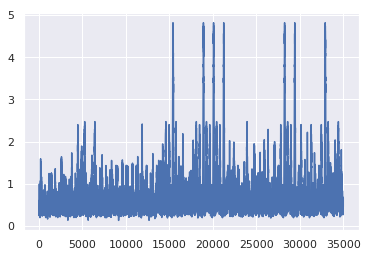

In [75]:
plt.plot(losses)

In [76]:
(min(losses), max(losses))

(tensor(0.1353, grad_fn=<L1LossBackward>),
 tensor(4.8161, grad_fn=<L1LossBackward>))